# Ethereum on-chain data
francesco.balsamo.20@ucl.ac.uk

Previous literature (Bovet, 2019) (Ante, 2021) has shown the existence of a causal relationships between cryptocurrency price movements and changes of its transaction network topology revealing the interplay between structural quantities, indicative of the collective behaviour of network users, and price movements. This project is an effort to extract meaningful information from cryptocurrency on-chain data to predict market dynamics using complex networks metrics and machine learning techniques.

## 1. Exploratory data analysis

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# set seaborn plotting theme
sns.set_theme()

In [13]:
%%bigquery eth_nr_trnsctn

SELECT DATE(block_timestamp) dt_rfrnc, count(distinct `hash`) nr_trnsctn, sum(value) value
FROM `ethereum_onchain.transactions`
where value > 0 
group by dt_rfrnc
order by dt_rfrnc

<AxesSubplot:ylabel='Nr. daily transactions'>

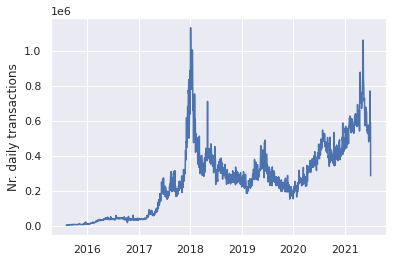

In [31]:
%matplotlib inline
eth_nr_trnsctn.plot(x = "dt_rfrnc", y = "nr_trnsctn", ylabel = 'Nr. daily transactions', xlabel='', legend = '')

In [ ]:
# plot lines
plt.plot(x, y, label = "line 1")
plt.plot(y, x, label = "line 2")
plt.plot(x, np.sin(x), label = "curve 1")
plt.plot(x, np.cos(x), label = "curve 2")
plt.legend()
plt.show()

In [ ]:
%%bigquery value

SELECT DATE(block_timestamp) dt_rfrnc, count(distinct `hash`) nr_trnsctn
FROM `ethereum_onchain.transactions`
where value > 0 
group by dt_rfrnc
order by dt_rfrnc

In [ ]:
sns.boxplot(data=data);

## 2. Network analysis

In [17]:
#pyspark --packages graphframes:graphframes:0.8.1-spark2.4-s_2.12
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [18]:
conf = pyspark.SparkConf().setAll([('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar'),
                                   ('spark.jars.packages', 'graphframes:graphframes:0.8.1-spark2.4-s_2.12')])

spark = SparkSession.builder \
    .master('yarn') \
    .appName('spark-bigquery-crypto') \
    .config(conf = conf) \
    .getOrCreate()

spark

In [19]:
bucket = "dataproc-staging-us-central1-397709471406-lrrymuq9"
spark.conf.set('temporaryGcsBucket', bucket)

In [21]:
from graphframes import *

In [20]:
# Load data from BigQuery.
table = 'charged-sector-315517:ethereum_onchain.transactions'

eth_transactions = spark.read.format('bigquery') \
                          .option('table', table) \
                          .option("filter", "DATE(block_timestamp) between '2020-01-30' and '2020-01-31'") \
                          .load()

eth_transactions.createOrReplaceTempView('eth_transactions')

In [22]:
edges = spark.sql('''
                    SELECT from_address as src, to_address as dst, value, block_timestamp, `hash` hash_trnsct
                    FROM eth_transactions
                    where from_address is not null and to_address is not null
                    ''')

CPU times: user 1.97 ms, sys: 0 ns, total: 1.97 ms
Wall time: 387 ms


In [23]:
nodes = edges \
         .select("src") \
         .union(edges.select("dst")) \
         .distinct() \
         .withColumnRenamed('src', 'id')

CPU times: user 5.61 ms, sys: 0 ns, total: 5.61 ms
Wall time: 90.7 ms


In [24]:
nodes.show(2)

+--------------------+
|                  id|
+--------------------+
|0x04b1a74269de8c5...|
|0x7fba406fa911d4c...|
+--------------------+
only showing top 2 rows



In [25]:
edges.show(2)

+--------------------+--------------------+-----+-------------------+--------------------+
|                 src|                 dst|value|    block_timestamp|         hash_trnsct|
+--------------------+--------------------+-----+-------------------+--------------------+
|0x00472c1e4275230...|0xcd111aa492a9c77...| 0E-9|2020-01-30 06:45:36|0xe2599ecd8178148...|
|0x00472c1e4275230...|0xcd111aa492a9c77...| 0E-9|2020-01-30 15:48:26|0xe9760c9d0261d61...|
+--------------------+--------------------+-----+-------------------+--------------------+
only showing top 2 rows



In [26]:
g = GraphFrame(nodes, edges)

CPU times: user 4.27 ms, sys: 17 µs, total: 4.29 ms
Wall time: 81.6 ms


### Centrality

In [ ]:
# g.inDegrees.join(g.outDegrees, 'id', 'outer').select('name', 'height').sort(desc("name"))

In [46]:
%%time
gDegrees = g.inDegrees.join(g.outDegrees, 'id', 'outer').na.fill(0)
gDegrees.sort(F.desc("inDegree")).show(5, False)
gDegrees.sort(F.desc("outDegree")).show(5, False)

+------------------------------------------+--------+---------+
|id                                        |inDegree|outDegree|
+------------------------------------------+--------+---------+
|0xdac17f958d2ee523a2206206994597c13d831ec7|118694  |0        |
|0xd8b93107d820d294cd8082a15c65261ee9d30790|44090   |0        |
|0xd1ceeeeee83f8bcf3bedad437202b6154e9f5405|19001   |0        |
|0x527b9715d99acfb7e1b01c6c864dc8402f2a3c3b|18031   |0        |
|0x716523231368d43bdfe1f06afe1c62930731ab13|17142   |0        |
+------------------------------------------+--------+---------+
only showing top 5 rows

+------------------------------------------+--------+---------+
|id                                        |inDegree|outDegree|
+------------------------------------------+--------+---------+
|0x4e57529d3630b4ad415bdedda508e40e4c632baf|0       |44414    |
|0xea674fdde714fd979de3edf0f56aa9716b898ec8|0       |26360    |
|0x7b804f619bc3cb1d6eaf470339255b6ad7bd46dd|1       |18031    |
|0x52bc44d53783

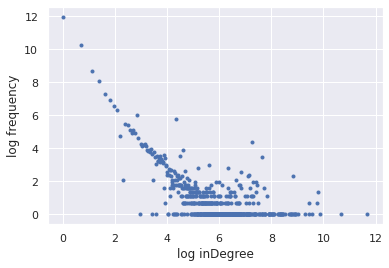

In [88]:
log_count_list = [np.log(x['count']) for x in g.inDegrees.drop("id").groupBy("inDegree").count().select('count').collect()]
log_inDegree_list = [np.log(x['inDegree']) for x in g.inDegrees.drop("id").groupBy("inDegree").count().select('inDegree').collect()]

plt.plot(log_inDegree_list, log_count_list, '.')
plt.ylabel('log frequency')
plt.xlabel('log inDegree')
plt.show()

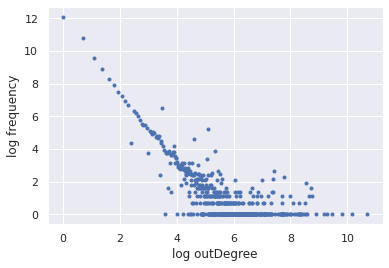

In [90]:
log_count_list = [np.log(x['count']) for x in g.outDegrees.drop("id").groupBy("outDegree").count().select('count').collect()]
log_outDegree_list = [np.log(x['outDegree']) for x in g.outDegrees.drop("id").groupBy("outDegree").count().select('outDegree').collect()]

plt.plot(log_outDegree_list, log_count_list, '.')
plt.ylabel('log frequency')
plt.xlabel('log outDegree')
plt.show()

In [ ]:
%%time
# Run PageRank algorithm and show top 10 results.
results = g.pageRank(resetProbability=0.01, maxIter=20)
results.vertices.select("id", "pagerank").sort(F.desc("pagerank")).show(10, False)

In [ ]:
%%time

# Perform SQL query.
eth_data = spark.sql(
    '''SELECT * FROM eth_transactions limit 1''') # WHERE DATE(block_timestamp) between "2020-01-01" and "2020-01-02" #distinct hash # where DATE(block_timestamp) = '2020-01-30' 
eth_data.show()
eth_data.printSchema()

In [ ]:
%%time
nodes = spark.sql('''
                    select --row_number() over () id, 
                    address id
                    from
                    (SELECT distinct from_address as address FROM eth_transactions
                            union
                            distinct SELECT distinct to_address as address FROM eth_transactions)
                    ''')

In [ ]:
spark = SparkSession.builder \
.appName("Python Spark SQL") \    \
.config("spark.jars.packages", "graphframes:graphframes:0.5.0-spark2.1-s_2.11") \
.getOrCreate()

In [17]:
# Load data from BigQuery.
eth_transactions = spark.read.format('bigquery') \
  .option('table', 'charged-sector-315517:ethereum_onchain.transactions') \
  .load()

eth_transactions.createOrReplaceTempView('eth_transactions')

In [43]:
spark = SparkSession.builder \
    .appName("Python Spark SQL") \
    .config("spark.jars.packages", "graphframes:graphframes:0.7.0-spark2.4-s_2.11") \
    .getOrCreate()

In [ ]:
!pyspark --packages graphframes:graphframes:graphframes:0.8.1-spark2.4-s_2.12

Python 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0] :: Anaconda, Inc. on linux
Type "help", "copyright", "credits" or "license" for more information.
Exception in thread "main" java.lang.IllegalArgumentException: requirement failed: Provided Maven Coordinates must be in the form 'groupId:artifactId:version'. The coordinate provided is: graphframes:graphframes:graphframes:0.8.1-spark2.4-s_2.12
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.deploy.SparkSubmitUtils$.$anonfun$extractMavenCoordinates$1(SparkSubmit.scala:1024)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:238)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at scala.collection.TraversableLike.map(TraversableLike.scala:238)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:231)
	

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder \
  .master('yarn') \
  .appName('spark-bigquery-crypto') \
  .config('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar') \
  .getOrCreate()

spark

In [ ]:
%%time

# Perform SQL query.
eth_data = spark.sql(
    '''SELECT count(distinct hash) FROM eth_transactions''') # WHERE DATE(block_timestamp) between "2020-01-01" and "2020-01-02"
eth_data.show() 
eth_data.printSchema()

+--------------------+
|count(DISTINCT hash)|
+--------------------+
|          1194735964|
+--------------------+

root
 |-- count(DISTINCT hash): long (nullable = false)

CPU times: user 206 ms, sys: 76.2 ms, total: 282 ms
Wall time: 21min 25s


In [ ]:
%%time

# Perform SQL query.
eth_data = spark.sql(
    '''SELECT count(distinct from_address) FROM eth_transactions''') # WHERE DATE(block_timestamp) between "2020-01-01" and "2020-01-02"
eth_data.show()
eth_data.printSchema()

In [7]:
# Perform SQL query.
eth_data = spark.sql(
    '''SELECT * FROM eth_transactions limit 10''')
eth_data.show()
# eth_data.printSchema()

+--------------------+------+-----------------+--------------------+--------------------+-----+-----+----------+--------------------+---------------------------+----------------+------------------------+------------+--------------+-------------------+------------+--------------------+
|                hash| nonce|transaction_index|        from_address|          to_address|value|  gas| gas_price|               input|receipt_cumulative_gas_used|receipt_gas_used|receipt_contract_address|receipt_root|receipt_status|    block_timestamp|block_number|          block_hash|
+--------------------+------+-----------------+--------------------+--------------------+-----+-----+----------+--------------------+---------------------------+----------------+------------------------+------------+--------------+-------------------+------------+--------------------+
|0x6f5542d56de7107...|658257|               85|0x00472c1e4275230...|0xcd111aa492a9c77...| 0E-9|65792|1000000000|0xe1fa8e848bba13d...|         

In [9]:
!pip install graphframes

In [4]:
from graphframes import *

ModuleNotFoundError: No module named 'graphframes'

In [ ]:
eth_data.write.format('bigquery') \
  .option('table', 'crypto_ethereum.transactions') \
  .save()

Py4JJavaError: An error occurred while calling o73.save.
: java.lang.RuntimeException: Failed to write to BigQuery
	at com.google.cloud.spark.bigquery.BigQueryWriteHelper.writeDataFrameToBigQuery(BigQueryWriteHelper.scala:94)
	at com.google.cloud.spark.bigquery.BigQueryInsertableRelation.insert(BigQueryInsertableRelation.scala:43)
	at com.google.cloud.spark.bigquery.BigQueryRelationProvider.createRelation(BigQueryRelationProvider.scala:116)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:46)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:70)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:68)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.doExecute(commands.scala:86)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:81)
	at org.apache.spark.sql.DataFrameWriter.$anonfun$runCommand$1(DataFrameWriter.scala:696)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:80)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:127)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:75)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:696)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:310)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:291)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: com.google.cloud.spark.bigquery.repackaged.com.google.cloud.bigquery.BigQueryException: Not found: Dataset charged-sector-315517:crypto_ethereum
	at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.bigquery.spi.v2.HttpBigQueryRpc.translate(HttpBigQueryRpc.java:115)
	at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.bigquery.spi.v2.HttpBigQueryRpc.create(HttpBigQueryRpc.java:220)
	at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.bigquery.BigQueryImpl$5.call(BigQueryImpl.java:369)
	at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.bigquery.BigQueryImpl$5.call(BigQueryImpl.java:366)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.gax.retrying.DirectRetryingExecutor.submit(DirectRetryingExecutor.java:105)
	at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.RetryHelper.run(RetryHelper.java:76)
	at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.RetryHelper.runWithRetries(RetryHelper.java:50)
	at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.bigquery.BigQueryImpl.create(BigQueryImpl.java:365)
	at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.bigquery.BigQueryImpl.create(BigQueryImpl.java:340)
	at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.bigquery.connector.common.BigQueryClient.createAndWaitFor(BigQueryClient.java:173)
	at com.google.cloud.spark.bigquery.BigQueryWriteHelper.finishedJob$lzycompute$1(BigQueryWriteHelper.scala:154)
	at com.google.cloud.spark.bigquery.BigQueryWriteHelper.finishedJob$1(BigQueryWriteHelper.scala:154)
	at com.google.cloud.spark.bigquery.BigQueryWriteHelper.loadDataToBigQuery(BigQueryWriteHelper.scala:178)
	at com.google.cloud.spark.bigquery.BigQueryWriteHelper.writeDataFrameToBigQuery(BigQueryWriteHelper.scala:91)
	... 31 more
Caused by: com.google.cloud.spark.bigquery.repackaged.com.google.api.client.googleapis.json.GoogleJsonResponseException: 404 Not Found
POST https://www.googleapis.com/bigquery/v2/projects/charged-sector-315517/jobs?prettyPrint=false
{
  "code" : 404,
  "errors" : [ {
    "domain" : "global",
    "message" : "Not found: Dataset charged-sector-315517:crypto_ethereum",
    "reason" : "notFound"
  } ],
  "message" : "Not found: Dataset charged-sector-315517:crypto_ethereum",
  "status" : "NOT_FOUND"
}
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.client.googleapis.json.GoogleJsonResponseException.from(GoogleJsonResponseException.java:146)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.client.googleapis.services.json.AbstractGoogleJsonClientRequest.newExceptionOnError(AbstractGoogleJsonClientRequest.java:118)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.client.googleapis.services.json.AbstractGoogleJsonClientRequest.newExceptionOnError(AbstractGoogleJsonClientRequest.java:37)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.client.googleapis.services.AbstractGoogleClientRequest$1.interceptResponse(AbstractGoogleClientRequest.java:428)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.client.http.HttpRequest.execute(HttpRequest.java:1111)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.client.googleapis.services.AbstractGoogleClientRequest.executeUnparsed(AbstractGoogleClientRequest.java:514)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.client.googleapis.services.AbstractGoogleClientRequest.executeUnparsed(AbstractGoogleClientRequest.java:455)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.client.googleapis.services.AbstractGoogleClientRequest.execute(AbstractGoogleClientRequest.java:565)
	at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.bigquery.spi.v2.HttpBigQueryRpc.create(HttpBigQueryRpc.java:218)
	... 43 more


In [ ]:
df = spark.read \
  .format('bigquery') \
  .option('table', 'crypto_ethereum.transactions') \
  .load()

df.printSchema()